# <span style="color:blue;">OpenPIV-Python-CPU Advanced Tutorial</span>

Please use the following link to run this notebook from Google Colab:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ali-sh-96/openpiv-python-cpu/blob/main/openpiv_cpu/tutorials/openpiv_python_cpu_advanced_tutorial.ipynb)

There is also a GPU version available for this notebook:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ericyang125/openpiv-python-gpu/blob/main/openpiv/tutorials/openpiv_python_gpu_tutorial_advanced.ipynb)

## <span style="color:blue;">Introduction</span>

This tutorial demonstrates the use of OpenPIV-Python-CPU for a large dataset. The dataset used for this tutorial are the synthetic images generated from a slice of the Johns Hopkins turbulent channel database:
> Perlman, E., Burns, R., Li, Y., & Meneveau, C. (2007, November). Data exploration of turbulence simulations using a database cluster. In Proceedings of the 2007 ACM/IEEE Conference on Supercomputing (pp. 1-11).

The images are 0.8 MP, and up to 1000 pairs are available in the public Google Drive. The output from the PIV function are compared with the underlying DNS data.

Note that downloading the dataset can take some time (~5 minutes). The first code block requires user input to authorize the Google Drive client to download the public data. To interact with the tutorial, you may change the parameters in the Colab forms.

See the References section for a complete description of the iterative multigrid approach in PIV analysis. In brief, at every iteration, the algorithm estimates a velocity field by computing the cross-correlation of square regions around measurement nodes, known as interrogation windows. The estimated field from the cross-correlation is a velocity field for the first iteration, whereas it serves only as a correction for the remaining iterations. This is because the estimated velocity field from the previous iterations is used to shift and deform the windows used in the next iteration, which can result in a more accurate estimation. In between iterations, the estimated velocity field can be processed by smoothing and validation routines. Smaller windows allow for more local estimates of the velocity at the risk of producing spurious vectors.

## <span style="color:blue;">Import the Dependencies</span>

In [ ]:
#@title Google Drive client authorization
#@markdown Please authorize the Google Drive client here.

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Folder id of the public data.
image_dir_id = '1IuzZlz7DjjKHptILpuzRAFRUioiAiqaX'
vel_dir_id = '185O3NOtyl0rn5GTLUIYYEOVLuipZddjW'

# Get the list of files on Drive.
image_file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(image_dir_id)}).GetList()
vel_file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(vel_dir_id)}).GetList()

# Sort the file list by title.
image_file_list = sorted(image_file_list, key=lambda i: i['title'])
vel_file_list = sorted(vel_file_list, key=lambda i: i['title'])

In [ ]:
#@title Import the needed libraries
#@markdown Run this block to import the dependencies.
import os
import pkg_resources
from glob import glob
import time
import numpy as np
import cv2

In [ ]:
#@title Install openpiv-python-cpu
#@markdown Run this block to install `openpiv-python-cpu`.
!pip install git+https://github.com/ali-sh-96/openpiv-python-cpu
from openpiv_cpu.cpu_process import piv_cpu
from openpiv_cpu.cpu_multiprocess import mp_cpu

# Get the path to the installed package
openpiv_path = pkg_resources.resource_filename('openpiv_cpu', '')
tutorial_path = os.path.join(openpiv_path, 'tutorials/')

  Cloning https://github.com/ali-sh-96/openpiv-python-cpu to /tmp/pip-req-build-syk87spg
  Running command git clone --filter=blob:none --quiet https://github.com/ali-sh-96/openpiv-python-cpu /tmp/pip-req-build-syk87spg
  Resolved https://github.com/ali-sh-96/openpiv-python-cpu to commit ad49be4b2c57513b9b9818a7f62aa9041311762d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 9.9 MB/s eta 0:00:00
  Created wheel for OpenPIV-Python-CPU: filename=OpenPIV_Python_CPU-1.1.0-py3-none-any.whl size=23766548 sha256=762f59a83ccd18d30ce14320c26f2270a5bf6bce47a99a59b4ec09168484a6e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-8qpees7p/wheels/6f/31/b7/db282a2e2db8f3ce11a5831a18d2ae8a26b43fadcd7ba7f225
Successfully built OpenPIV-Python-CPU


## <span style="color:blue;">Download the Dataset</span>

In [ ]:
from tqdm import tqdm
from time import sleep

#@markdown Choose the set of image pairs to download:
start_index = 50 #@param {type:"slider", min:0, max:1000, step:1}
end_index = 100 #@param {type:"slider", min:0, max:1000, step:1}
assert start_index < end_index, 'start_index must be smaller than end_index'

#@markdown Both image data and velocity data will be downloaded. The velocity data is for accuracy validation later on.

# Resolution of the images/size of the fields.
im_shape = (512, 6434 // 4)
num_images = 1000

# Directory on the VM.
cwd = os.getcwd()

# Get list of images already on drive.
downloaded_image_list = sorted(glob('*.tiff'))
downloaded_vel_list = sorted(glob('*.npy'))

# Download the files.
download_list = [image_file_list[i] for i in range(2 * start_index, 2 * end_index) if image_file_list[i]['title'] not in downloaded_image_list]
print('Downloading {} image-data files:'.format(len(download_list))), sleep(0.25)
for file in tqdm(download_list):
    downloaded = drive.CreateFile({'id': file['id']})
    downloaded.GetContentFile(file['title'])

# Download the velocity fields to validate.
index_list = list(range(4)) + list(range(4 + start_index, 4 + end_index)) + list(range(4 + num_images + start_index, 4 + num_images + end_index))
download_list = [vel_file_list[i] for i in index_list if vel_file_list[i]['title'] not in downloaded_vel_list]
print('Downloading {} velocity-data files:'.format(len(download_list))), sleep(0.25)
for file in tqdm(download_list):
    downloaded = drive.CreateFile({'id': file['id']})
    downloaded.GetContentFile(file['title'])

# Make file lists.
frame_a_list = ['{}/jh_{:04d}_a.tiff'.format(cwd, i) for i in range(start_index, end_index)]
frame_b_list = ['{}/jh_{:04d}_b.tiff'.format(cwd, i) for i in range(start_index, end_index)]
u0_list = ['{}/u_{:04d}.npy'.format(cwd, i) for i in range(start_index, end_index)]
v0_list = ['{}/v_{:04d}.npy'.format(cwd, i) for i in range(start_index, end_index)]
index_bounds = (start_index, end_index)
num_pairs = end_index - start_index

print('Downloaded image pairs and data {} through {}.'.format(*index_bounds))

100%|██████████| 100/100 [01:42<00:00,  1.03s/it]


100%|██████████| 104/104 [01:33<00:00,  1.11it/s]

Downloaded image pairs and data 50 through 100.


## <span style="color:blue;">PIV Parameters</span>

In [ ]:
#@title Geometry settings
#@markdown Shape of the images in pixels. `(512, 1608)` is the value for this dataset.
frame_shape = (512, 6434 // 4) #@param {type:"raw"}

#@markdown Width and height of the windows. Only multiples of 8 and powers of 2 are supported.
min_search_size = 8 #@param [8, 16, 32] {type:"raw"}

#@markdown Number of iterations performed at each window size. You can enter a tuple, where the number of tuple indexes control the number of mesh refinements. For example `(1, 2, 2,)` for a mimimum window size of 8 would perform 1 iteration at 32, 2 iterations at 16, and 2 iterations at 8.
search_size_iters = (1, 2, 2,) #@param {type:"raw"}


#@markdown The ratio of overlap between adjacent windows. You can enter a number between 0 and 1 or a tuple to control the overlap for all different window sizes. This is almost always left as 0.5. Still, in certain cases, it is also possible to use 75% overlap for the smallest window size.
overlap_ratio = (0.5, 0.5, 0.5,) #@param {type:"raw"}

#@markdown The ratio (between 0 and 1) used to shrink the search size during the initial iteration for extended search PIV.
shrink_ratio = 1 #@param {type:"raw"}

In [ ]:
#@title Correlation settings
#@markdown Order of spline interpolation used for window deformation.
deforming_order = 3 #@param [1, 2, 3] {type:"raw"}

#@markdown Whether to normalize the window intensity by subtracting the mean value. Default of `True` is recommended.
normalize = True #@param ["True", "False"] {type:"raw"}

#@markdown Method to estimate subpixel location of the peak at each iteration.
subpixel_method = "gaussian" #@param ["gaussian", "centroid", "parabolic"] {type:"string"}

#@markdown Size-factor of the 2D FFT. A value of 2 is recommended for the smallest window size.
n_fft = (1, 2, 2,) #@param {type:"raw"}

#@markdown Ratio (between 0 and 1) of the previous velocity used to deform each frame at every iteration. A default value of 0.5 is recommended to reduce bias errors. A value of 1 corresponds to only second frame deformation.
deforming_par = 0.5 #@param {type:"raw"}

#@markdown Batch size for cross-correlation at every iteration. On a CPU, vectorizing the cross-correlation often leads to a decreased performance, and consequently, a batch size of 1 is recommended. Set to `"full"` for a fully vectorized cross-correlation and compare the performance.
corr_batch_size = 1 #@param {type:"raw"}

In [ ]:
#@title Validation settings
#@markdown Method of signal-to-noise-ratio measurement.
s2n_method = "peak2peak" #@param ["peak2peak", "peak2mean", "peak2energy"] {type:"string"}

#@markdown Half size of the region around the first correlation peak to ignore for finding the second peak. Default of 2 is only used if signal-to-noise-ratio measurement method is `"peak2peak"`.
s2n_size = 2 #@param [1, 2, 3] {type:"raw"}

#@markdown Size parameter for validation kernel. Note that the actual kernel size is `2 * size + 1`.
validation_size = 1 #@param [1, 2, 3] {type:"raw"}

#@markdown The validation methods are selected by defining a validation tolerance for each specific method. You have the option to employ a combination of these methods by assigning different validation tolerances to each. When a tolerance is set to `None` for a particular method, it will be bypassed during the validation process. The default method is median validation with a tolerance of 2 for the entire process. The available methods are signal-to-noise-ratio, median, median-absolute-deviation, mean, and root-mean-squared.
s2n_tol = None #@param {type:"raw"}
median_tol = 2 #@param {type:"raw"}
mad_tol = None #@param {type:"raw"}
mean_tol = None #@param {type:"raw"}
rms_tol = None #@param {type:"raw"}

In [ ]:
#@title Replacement settings
#@markdown Number of iterations per replacement cycle. Note that this parameter is important if the replacement method is iterative (`"median"` or `"mean"`). For `"spring"` method, a value of 1 or 2 is sufficient.
num_replacing_iters = 1 #@param {type:"raw"}

#@markdown Method to use for outlier replacement.
replacing_method = "spring" #@param ["spring", "mean", "median"] {type:"string"}

#@markdown Size parameter for replacement kernel. Note that the actual kernel size is `2 * size + 1`.
replacing_size = 1 #@param [1, 2, 3] {type:"raw"}

#@markdown Whether to revalidate the fields after every replecement iteration. Default of `True` is recommended for iterative replacement methods.
revalidate = True #@param ["True", "False"] {type:"raw"}

In [ ]:
#@title Smoothing settings
#@markdown Whether to smooth the fields. Ignored for the last iteration.
smooth = True #@param ["True", "False"] {type:"raw"}
#@markdown Smoothing parameter to pass to smoothn to apply to the velocity fields. Set to `None` for automatic smoothing.
smoothing_par = None #@param {type:"raw"}

In [ ]:
#@title Scaling settings
#@markdown Time delay separating the two frames.
dt = 1 #@param {type:"raw"}

#@markdown Scaling factor to apply to the velocity fields.
scaling_par = 1 #@param {type:"raw"}

In [ ]:
#@title Mask settings
#@markdown 2D array with non-zero values indicating the masked locations. See the basic tutorial for an example on masking.
mask = None #@param ["None"] {type:"raw"}

In [ ]:
#@title Float data type setting
#@markdown Float data type. By default, single precision floating point is used. However, if you need higher precision and want to utilize double precision, you can set the float type to `"float64"`.
dtype_f = "float32" #@param ["float32", "float64"] {type:"string"}

## <span style="color:blue;">Processing</span>

In [ ]:
#@title Batch size
#@markdown Batch size here is the number of pairs to process at once.
batch_size = 14 #@param {type:"slider", min:0, max:200, step:1}
if batch_size < 1:
    batch_size = 1
elif batch_size > num_pairs:
    batch_size = num_pairs
num_batches = np.ceil(num_pairs / batch_size).astype(int)

In [ ]:
#@title Initialize the PIV process
#@markdown Running this block will initialize the coordinates, field mask, and some functions.

# Set PIV settings.
settings = {}
settings["search_size_iters"] = search_size_iters
settings["overlap_ratio"] = overlap_ratio
settings["shrink_ratio"] = shrink_ratio
settings["deforming_order"] = deforming_order
settings["normalize"] = normalize
settings["subpixel_method"] = subpixel_method
settings["n_fft"] = n_fft
settings["deforming_par"] =deforming_par
settings["batch_size"] = corr_batch_size
settings["s2n_method"] = s2n_method
settings["s2n_size"] = s2n_size
settings["validation_size"] = validation_size
settings["s2n_tol"] = s2n_tol
settings["median_tol"] = median_tol
settings["mad_tol"] = mad_tol
settings["mean_tol"] = mean_tol
settings["rms_tol"] = rms_tol
settings["num_replacing_iters"] = num_replacing_iters
settings["replacing_method"] = replacing_method
settings["replacing_size"] = replacing_size
settings["revalidate"] = revalidate
settings["smooth"] = smooth
settings["smoothing_par"] = smoothing_par
settings["dt"] = dt
settings["scaling_par"] = scaling_par
settings["mask"] = mask
settings["dtype_f"] = dtype_f

# Initialize process.
process = piv_cpu(frame_shape=frame_shape, min_search_size=min_search_size, **settings)
x, y = process.coords
y = y[::-1]
field_mask = process.field_mask
field_shape = field_mask.shape

# Function to read an image.
def read_image(path):
    return cv2.imread(path, cv2.IMREAD_ANYDEPTH)

# Function for processing.
def func(pair, index):
    frame_a, frame_b = pair

    u, v = process(frame_a, frame_b)
    v = -v
    u[field_mask] = v[field_mask] = 0
    loc = process.val_locations

    return u, v, loc

In [ ]:
#@title Perform PIV processing
#@markdown Running this block will process all batches. As several operations are already vectorized, using all cores may overload the CPU. In practice using half of the available cores is recommended. Note that multiprocessing is not available in an interactive prompt. To use multiprocessing, save your code in a .py file.
multiprocess = mp_cpu(func, n_cpus=1)

process_wall_time = 0
m, n = field_shape
u = np.empty((num_pairs, m, n))
v = np.empty((num_pairs, m, n))
loc = np.empty((num_pairs, m, n), dtype=bool)
for k_batches in tqdm(range(*(0, num_batches))):
    # Read images.
    pair_start = k_batches * batch_size
    pair_end = min(pair_start + batch_size, num_pairs)
    frame_a_arrays = list(map(read_image, frame_a_list[pair_start: pair_end]))
    frame_b_arrays = list(map(read_image, frame_b_list[pair_start: pair_end]))

    # List pf pairs to be processed.
    pairs = [(frame_a_arrays[k_pairs], frame_b_arrays[k_pairs],) for k_pairs in range(pair_end - pair_start)]
    indices = [i + pair_start for i in range(pair_end - pair_start)]

    # Perform a batch.
    start_time = time.time()
    res = multiprocess.run(pairs, indices)
    process_wall_time += time.time() - start_time
    u[pair_start:pair_end] = np.array(list(map(lambda sublist: sublist[0], res)))
    v[pair_start:pair_end] = np.array(list(map(lambda sublist: sublist[1], res)))
    loc[pair_start:pair_end] = np.array(list(map(lambda sublist: sublist[2], res)))
    pairs = None
    indices = None
# The performance of the function is reported.
print('\nComputation time for {} image pairs was {:.3f} s.'.format(num_pairs, process_wall_time))
print('Average time per image pair was {:.3f} s.'.format(process_wall_time / num_pairs))

100%|██████████| 4/4 [03:34<00:00, 53.72s/it]


Computation time for 50 image pairs was 214.670 s.
Average time per image pair was 4.293 s.


## <span style="color:blue;">Results</span>

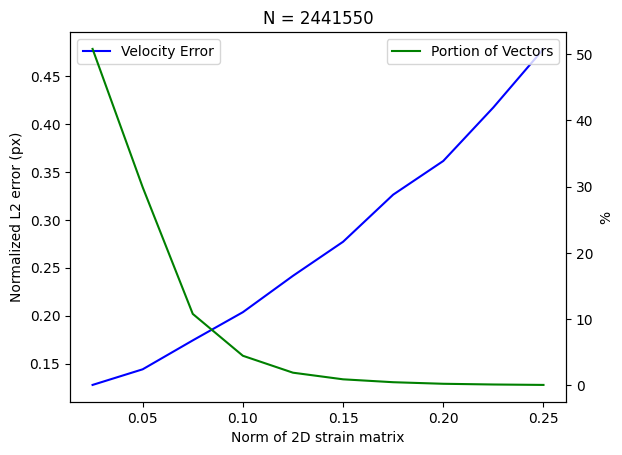

In [ ]:
#@title Accuracy
#@markdown This code block will estimate the accuracy of the outputs as a function of gradient magnitude.

import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from math import sqrt
%matplotlib inline

# Trim edges for the error calculation.
trim = 2
t = slice(trim, -trim)

# Load the x and y coordinates.
x0 = np.load('_x.npy')
y0 = np.load('_y.npy')

# Create arrays to store the error values.
m, n = field_shape
gradient_mag = np.zeros((num_pairs, m - 2 * trim, n - 2 * trim))
vel_error_mag = np.zeros((num_pairs, m - 2 * trim, n - 2 * trim))

# The accuracy of the fields is evaluated.
for i in range(num_pairs):
    # Load the original velocity field.
    u0_ = np.load(u0_list[i])
    v0_ = np.load(v0_list[i])

    # Create interpolants for the original data.
    u0_interp = interp2d(x0[0, :], y0[:, 0], u0_)
    v0_interp = interp2d(x0[0, :], y0[:, 0], v0_)

    # Interpolate the original data.
    u0 = np.flip(u0_interp(x[0, :], y[:, 0]), axis=0)
    v0 = np.flip(v0_interp(x[0, :], y[:, 0]), axis=0)

    # Compute error.
    u_error = u[i, :, :] - u0
    v_error = v[i, :, :] - v0
    vel_error_mag[i, :, :] = np.linalg.norm(np.stack([u_error, v_error]), axis=0)[t, t]

    # Compute gradients.
    spacing = process.min_search_size - process.overlap_ratio[-1] * process.min_search_size
    u_y, u_x = np.gradient(u0, spacing)
    v_y, v_x = np.gradient(v0, spacing)

    # Compute norm of the gradient matrix.
    gradient_mag[i] = np.linalg.norm(np.stack([u_x, u_y, v_x, v_y]), axis=0)[t, t]

# Compute the histogram values.
bins = np.linspace(0, 0.25, 11)
gradient_hist, hist_bins = np.histogram(gradient_mag, bins)

# Get the error in each bin.
vel_error_bins = np.zeros(gradient_hist.shape)
zero = np.zeros_like(gradient_mag)
for i in range(0, len(bins) - 1):
    if gradient_hist[i] > 0:
        vel_error_bins[i] = np.linalg.norm(np.where((gradient_mag > hist_bins[i]) * (gradient_mag <= hist_bins[i + 1]), vel_error_mag, zero)) / sqrt(gradient_hist[i])
    else:
        vel_error_bins[i] = 0

# Plot the error.
fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(bins[1:], vel_error_bins, 'b')
ax2.plot(bins[1:], gradient_hist / vel_error_mag.size * 100, 'g')

# Format the plot.
ax1.set_xlabel('Norm of 2D strain matrix')
ax1.set_ylabel('Normalized L2 error (px)')
ax2.set_ylabel('%')
ax1.legend(['Velocity Error'], loc='upper left')
ax2.legend(['Portion of Vectors'], loc='upper right')
ax1.set_title('N = {}'.format(vel_error_mag.size))
plt.show()

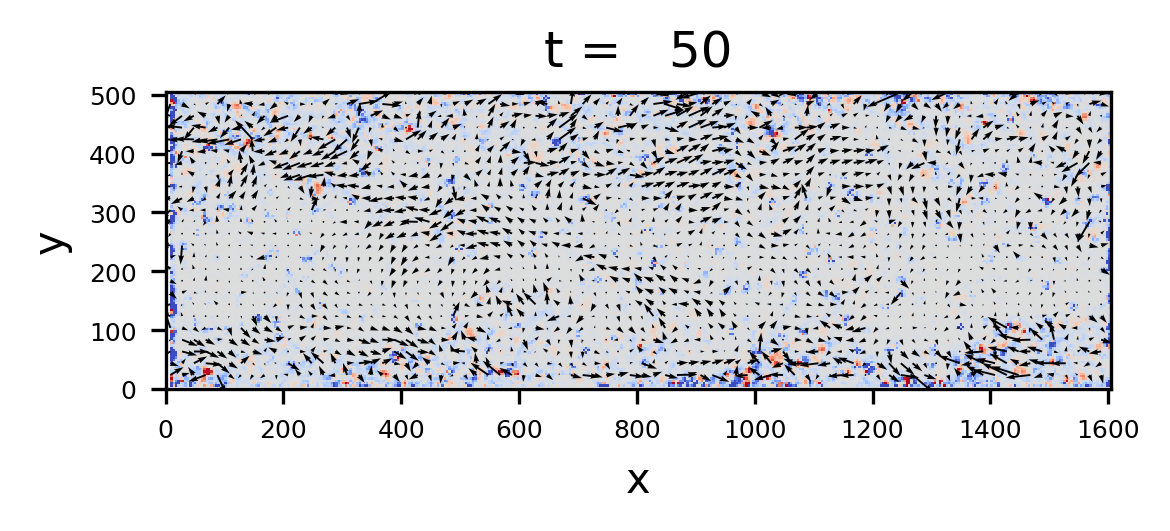

In [ ]:
#@title Visualization
#@markdown The fluctuating velocities can be visualized as vectors.

import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp2d
from matplotlib import animation, RcParams
from IPython.display import HTML
import matplotlib.colors as colors
%matplotlib inline
matplotlib.rcParams['animation.embed_limit'] = 2**128

#@markdown Choose the scalar quantity to plot as color:
color_var = "Q-criterion" #@param ['None', 'Reynolds Stress', 'vorticity', 'Q-criterion'] {type:"string"}

#@markdown Choose the density of vectors to plot. The kth vector will be plotted.
k = 5 #@param {type:"number"}
s_i = slice(1, m - 1, k)
s_j = slice(1, n - 1, k)

#@markdown Set width and scale parameters for the vectors.
vector_scale = 50 #@param {type:"number"}
vector_width = 0.002 #@param {type:"number"}

#@markdown Set frames per second (fps) for the animation.
fps = 3 #@param {type:"number"}

# Load the mean data.
u_mean_ = np.load('_u.npy')
v_mean_ = np.load('_v.npy')

# Create interpolants for the mean velocity.
u0_interp = interp2d(x0[0, :], y0[:, 0], u_mean_)
v0_interp = interp2d(x0[0, :], y0[:, 0], v_mean_)

# Interpolate the mean onto the output grid.
u_mean = np.flip(u0_interp(x[0, :], y[:, 0]), axis=0)
v_mean = np.flip(v0_interp(x[0, :], y[:, 0]), axis=0)

# Get the velocity flucatuations.
up = (u - u_mean)
vp = (v - v_mean)

# Compute the scalar values to plot.
if color_var == 'Reynolds Stress':
    plot_var = up * vp
    hr = np.percentile(np.absolute(plot_var[:, 1:-1, 1:-1]), 99)
elif color_var == 'vorticity':
    u_y = -np.gradient(u, spacing, axis=1)
    v_x = np.gradient(v, spacing, axis=2)
    plot_var = v_x - u_y
    hr = np.percentile(np.absolute(plot_var[:, 1:-1, 1:-1]), 99)
elif color_var == 'Q-criterion':
    u_x = np.gradient(u, spacing, axis=2)
    u_y = -np.gradient(u, spacing, axis=1)
    v_x = np.gradient(v, spacing, axis=2)
    v_y = -np.gradient(v, spacing, axis=1)
    plot_var = -0.5 * (u_x**2 + 2*u_y*v_x + v_y**2)
    hr = np.percentile(np.absolute(plot_var[:, 1:-1, 1:-1]), 99)
else:
    plot_var = np.zeros_like(x)

# Create plots.
fig, ax = plt.subplots(figsize=(4, 2), dpi=300, tight_layout=True)
txt_title = ax.set_title('')
ax.set_xlabel('x')  # Use set_xlabel instead of set_x_label
ax.set_ylabel('y')  # Use set_ylabel instead of set_y_label

# Plot quiver.
quad = ax.pcolormesh(x[1:, 1:], y[1:, 1:], plot_var[0, 1:-1, 1:-1], cmap='coolwarm', norm=colors.Normalize(vmin=-hr, vmax=hr))
q = ax.quiver(x[s_i, s_j], y[s_i, s_j], up[0, s_i, s_j], vp[0, s_i, s_j], scale=vector_scale, width=vector_width)
plt.axis('scaled')

# Modify tick labels and ticks.
ticks_step = 100
ax.set_xticks(np.arange(0, x[0, -1], 2 * ticks_step))
ax.set_yticks(np.arange(0, y[0, -1], ticks_step))
ax.tick_params(axis='both', which='both', labelsize=6)

# Define the function to draw the frames.
def drawframe(i):
    # Set the contour data.
    quad.set_array(plot_var[i, 1:-1, 1:-1].ravel())

    # Set the quiver data.
    q.set_UVC(up[i, s_i, s_j], vp[i, s_i, s_j])
    txt_title.set_text('t = {0:4d}'.format(index_bounds[0] + i))

# Animate the frames as html.
anim = animation.FuncAnimation(fig, drawframe, frames=num_pairs, interval=1000/fps, blit=False, cache_frame_data=False)
HTML(anim.to_html5_video())


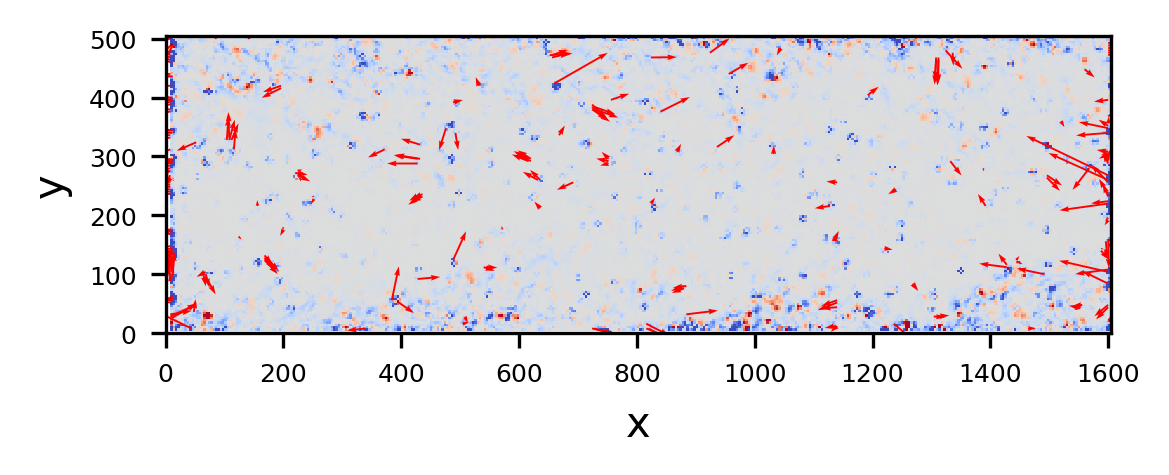

In [ ]:
#@title Replacements
#@markdown Choose the vector field to plot:
index = 0 #@param {type:"slider", min:0, max:200, step:1}
if index < 0:
    index = 0
elif index > num_pairs:
    index = num_pairs

#@markdown Choose the scalar quantity to plot as color:
color_var = "Q-criterion" #@param ['None', 'Reynolds Stress', 'vorticity', 'Q-criterion'] {type:"string"}

#@markdown Choose the density of vectors to plot. The kth vector will be plotted.
k = 1 #@param {type:"number"}
s_i = slice(1, m - 1, k)
s_j = slice(1, n - 1, k)

#@markdown Set width and scale parameters for the vectors.
vector_scale = 25 #@param {type:"number"}
vector_width = 0.002 #@param {type:"number"}

#@markdown Only show the replaced vectors during the last iteration:
is_replaced = True #@param ["True", "False"] {type:"raw"}

# Compute the scalar values to plot.
if color_var == 'Reynolds Stress':
    plot_var = up * vp
    hr = np.percentile(np.absolute(plot_var[:, 1:-1, 1:-1]), 99)
elif color_var == 'vorticity':
    u_y = -np.gradient(u, spacing, axis=1)
    v_x = np.gradient(v, spacing, axis=2)
    plot_var = v_x - u_y
    hr = np.percentile(np.absolute(plot_var[:, 1:-1, 1:-1]), 99)
elif color_var == 'Q-criterion':
    u_x = np.gradient(u, spacing, axis=2)
    u_y = -np.gradient(u, spacing, axis=1)
    v_x = np.gradient(v, spacing, axis=2)
    v_y = -np.gradient(v, spacing, axis=1)
    plot_var = -0.5 * (u_x**2 + 2*u_y*v_x + v_y**2)
    hr = np.percentile(np.absolute(plot_var[:, 1:-1, 1:-1]), 99)
else:
    plot_var = np.zeros_like(x)

loc0 = loc[index, s_i, s_j]

# Create plots.
fig, ax = plt.subplots(figsize=(4, 2), dpi=300, tight_layout=True)
txt_title = ax.set_title('')
ax.set_xlabel('x')  # Use set_xlabel instead of set_x_label
ax.set_ylabel('y')  # Use set_ylabel instead of set_y_label

# Plot quiver.
ax.pcolormesh(x[1:, 1:], y[1:, 1:], plot_var[index, 1:-1, 1:-1], cmap='coolwarm', norm=colors.Normalize(vmin=-hr, vmax=hr))
if not is_replaced:
    ax.quiver(x[s_i, s_j][~loc0], y[s_i, s_j][~loc0], up[index, s_i, s_j][~loc0], vp[index, s_i, s_j][~loc0], scale=vector_scale, width=vector_width)
ax.quiver(x[s_i, s_j][loc0], y[s_i, s_j][loc0], up[index, s_i, s_j][loc0], vp[index, s_i, s_j][loc0], color="red", width=vector_width, scale=vector_scale)
plt.axis('scaled')

# Modify tick labels and ticks.
ticks_step = 100
ax.set_xticks(np.arange(0, x[0, -1], 2 * ticks_step))
ax.set_yticks(np.arange(0, y[0, -1], ticks_step))
ax.tick_params(axis='both', which='both', labelsize=6)
plt.show()

## <span style="color:blue;">Conclusions</span>

A large dataset was processed using OpenPIV-Python-CPU. Increasing the number of iterations resulted in better accuracy. Decreasing the size or increasing the overlap for the final interrogation windows resulted in a denser velocity field. As long as good images are fed to the algorithm, the processing time would depend on the size of the images. If there are a lot of spurious vectors present, considerable time may be required to replace the outliers.

## <span style="color:blue;">References</span>

> Raffel, M., Willert, C. E., & Kompenhans, J. (1998). Particle image velocimetry: a practical guide (Vol. 2, p. 218). Berlin: Springer.

> Scarano, F., & Riethmuller, M. L. (1999). Iterative multigrid approach in PIV image processing with discrete window offset. Experiments in Fluids, 26, 513-523.
    
> Meunier, P., & Leweke, T. (2003). Analysis and treatment of errors due to high velocity gradients in particle image velocimetry. Experiments in fluids, 35(5), 408-421.

> Perlman, E., Burns, R., Li, Y., & Meneveau, C. (2007, November). Data exploration of turbulence simulations using a database cluster. In Proceedings of the 2007 ACM/IEEE Conference on Supercomputing (pp. 1-11).

> Garcia, D. (2010). Robust smoothing of gridded data in one and higher dimensions with missing values. Computational statistics & data analysis, 54(4), 1167-1178.

> Shirinzad, A., Jaber, K., Xu, K., & Sullivan, P. E. (2023). An Enhanced Python-Based Open-Source Particle Image Velocimetry Software for Use with Central Processing Units. Fluids, 8(11), 285.